In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

# Загрузка датасета
df = pd.read_csv('Petitions.csv')
df = df[['public_petition_text', 'reason_category']].dropna()
df = df[:10000]
print(f"Исходный размер датасета: {df.shape}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Миша\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Миша\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Исходный размер датасета: (10000, 2)


In [2]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('russian'))
        self.stemmer = SnowballStemmer('russian')
        self.vocab = {}
        self.reverse_vocab = {}
        
    def clean_text(self, text):
        # Приведение к нижнему регистру
        text = text.lower()
        # Удаление специальных символов и цифр
        text = re.sub(r'[^а-яё\s]', '', text)
        # Удаление лишних пробелов
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def tokenize(self, text):
        tokens = word_tokenize(text, language='russian')
        # Удаление стоп-слов и стемминг
        tokens = [self.stemmer.stem(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        return tokens
    
    def build_vocab(self, tokens_list, min_freq=2):
        # Подсчет частот слов
        word_freq = Counter()
        for tokens in tokens_list:
            word_freq.update(tokens)
        
        # Создание словаря
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.vocab[word] = idx
                idx += 1
        
        # Обратный словарь
        self.reverse_vocab = {idx: word for word, idx in self.vocab.items()}
        
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            cleaned = self.clean_text(text)
            tokens = self.tokenize(cleaned)
            sequence = [self.vocab.get(token, 1) for token in tokens]  # 1 = <UNK>
            sequences.append(sequence)
        return sequences

# Применение предобработки
preprocessor = TextPreprocessor()

# Очистка и токенизация текстов
texts = df['public_petition_text'].tolist()
cleaned_texts = [preprocessor.clean_text(text) for text in texts]
tokenized_texts = [preprocessor.tokenize(text) for text in cleaned_texts]

# Построение словаря
preprocessor.build_vocab(tokenized_texts, min_freq=3)
sequences = preprocessor.texts_to_sequences(texts)

print(f"Размер словаря: {len(preprocessor.vocab)}")
print(f"Пример токенизированного текста: {tokenized_texts[0][:10]}")

Размер словаря: 3206
Пример токенизированного текста: ['снег', 'дорог']


In [3]:
class SkipGramDataset(Dataset):
    def __init__(self, sequences, window_size=2):
        self.data = []
        self.window_size = window_size
        
        for sequence in sequences:
            for i, target_word in enumerate(sequence):
                # Контекстные слова
                start = max(0, i - window_size)
                end = min(len(sequence), i + window_size + 1)
                
                for j in range(start, end):
                    if j != i:  # Исключаем целевое слово
                        self.data.append((target_word, sequence[j]))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0], dtype=torch.long), \
               torch.tensor(self.data[idx][1], dtype=torch.long)

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Инициализация весов
        self.input_embedding.weight.data.uniform_(-1, 1)
        self.output_embedding.weight.data.uniform_(-1, 1)
    
    def forward(self, target_word, context_word):
        # Входные эмбеддинги для целевых слов
        input_embeds = self.input_embedding(target_word)
        
        # Выходные эмбеддинги для контекстных слов
        output_embeds = self.output_embedding(context_word)
        
        # Скалярное произведение + сигмоида для вероятности
        scores = torch.sum(input_embeds * output_embeds, dim=1)
        return torch.sigmoid(scores)

# Параметры модели
VOCAB_SIZE = len(preprocessor.vocab)
EMBEDDING_DIM = 100
WINDOW_SIZE = 2
BATCH_SIZE = 512
LEARNING_RATE = 0.001
EPOCHS = 10

# Создание датасета и загрузчика
skipgram_dataset = SkipGramDataset(sequences, WINDOW_SIZE)
dataloader = DataLoader(skipgram_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Инициализация модели
skipgram_model = SkipGram(VOCAB_SIZE, EMBEDDING_DIM)
criterion = nn.BCELoss()
optimizer = optim.Adam(skipgram_model.parameters(), lr=LEARNING_RATE)

# Обучение SkipGram
print("Обучение SkipGram модели...")
skipgram_model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_idx, (target_words, context_words) in enumerate(dataloader):
        optimizer.zero_grad()
        
        predictions = skipgram_model(target_words, context_words)
        loss = criterion(predictions, torch.ones_like(predictions))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}')

Обучение SkipGram модели...
Epoch 1/10, Loss: 1.2017
Epoch 2/10, Loss: 0.7754
Epoch 3/10, Loss: 0.5102
Epoch 4/10, Loss: 0.3172
Epoch 5/10, Loss: 0.1869
Epoch 6/10, Loss: 0.1063
Epoch 7/10, Loss: 0.0595
Epoch 8/10, Loss: 0.0333
Epoch 9/10, Loss: 0.0190
Epoch 10/10, Loss: 0.0112


In [4]:
class CBOWDataset(Dataset):
    def __init__(self, sequences, window_size=2):
        self.data = []
        self.window_size = window_size
        
        for sequence in sequences:
            for i, target_word in enumerate(sequence):
                # Контекстные слова
                start = max(0, i - window_size)
                end = min(len(sequence), i + window_size + 1)
                
                context_words = []
                for j in range(start, end):
                    if j != i:  # Исключаем целевое слово
                        context_words.append(sequence[j])
                
                if len(context_words) > 0:
                    self.data.append((context_words, target_word))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        context_words, target_word = self.data[idx]
        return torch.tensor(context_words, dtype=torch.long), \
               torch.tensor(target_word, dtype=torch.long)

def collate_fn(batch):
    context_words, target_words = zip(*batch)
    
    # Выравнивание длины последовательностей
    max_len = max(len(ctx) for ctx in context_words)
    padded_contexts = []
    
    for ctx in context_words:
        if len(ctx) < max_len:
            padded = torch.cat([ctx, torch.zeros(max_len - len(ctx), dtype=torch.long)])
        else:
            padded = ctx
        padded_contexts.append(padded)
    
    return torch.stack(padded_contexts), torch.stack(target_words)

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
        # Инициализация весов
        self.embeddings.weight.data.uniform_(-1, 1)
    
    def forward(self, context_words):
        # Усреднение эмбеддингов контекстных слов
        context_embeds = self.embeddings(context_words)
        context_avg = torch.mean(context_embeds, dim=1)
        
        # Линейный слой для предсказания
        output = self.linear(context_avg)
        return output

# Создание датасета и загрузчика для CBOW
cbow_dataset = CBOWDataset(sequences, WINDOW_SIZE)
cbow_dataloader = DataLoader(cbow_dataset, batch_size=BATCH_SIZE, 
                           shuffle=True, collate_fn=collate_fn)

# Инициализация CBOW модели
cbow_model = CBOW(VOCAB_SIZE, EMBEDDING_DIM)
criterion_cbow = nn.CrossEntropyLoss()
optimizer_cbow = optim.Adam(cbow_model.parameters(), lr=LEARNING_RATE)

# Обучение CBOW
print("Обучение CBOW модели...")
cbow_model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_idx, (context_words, target_words) in enumerate(cbow_dataloader):
        optimizer_cbow.zero_grad()
        
        predictions = cbow_model(context_words)
        loss = criterion_cbow(predictions, target_words)
        
        loss.backward()
        optimizer_cbow.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(cbow_dataloader):.4f}')

Обучение CBOW модели...
Epoch 1/10, Loss: 7.3671
Epoch 2/10, Loss: 6.4457
Epoch 3/10, Loss: 5.9967
Epoch 4/10, Loss: 5.6584
Epoch 5/10, Loss: 5.3836
Epoch 6/10, Loss: 5.1626
Epoch 7/10, Loss: 4.9736
Epoch 8/10, Loss: 4.8039
Epoch 9/10, Loss: 4.6624
Epoch 10/10, Loss: 4.5300


Размерность SkipGram эмбеддингов: (3206, 100)
Размерность CBOW эмбеддингов: (3206, 100)


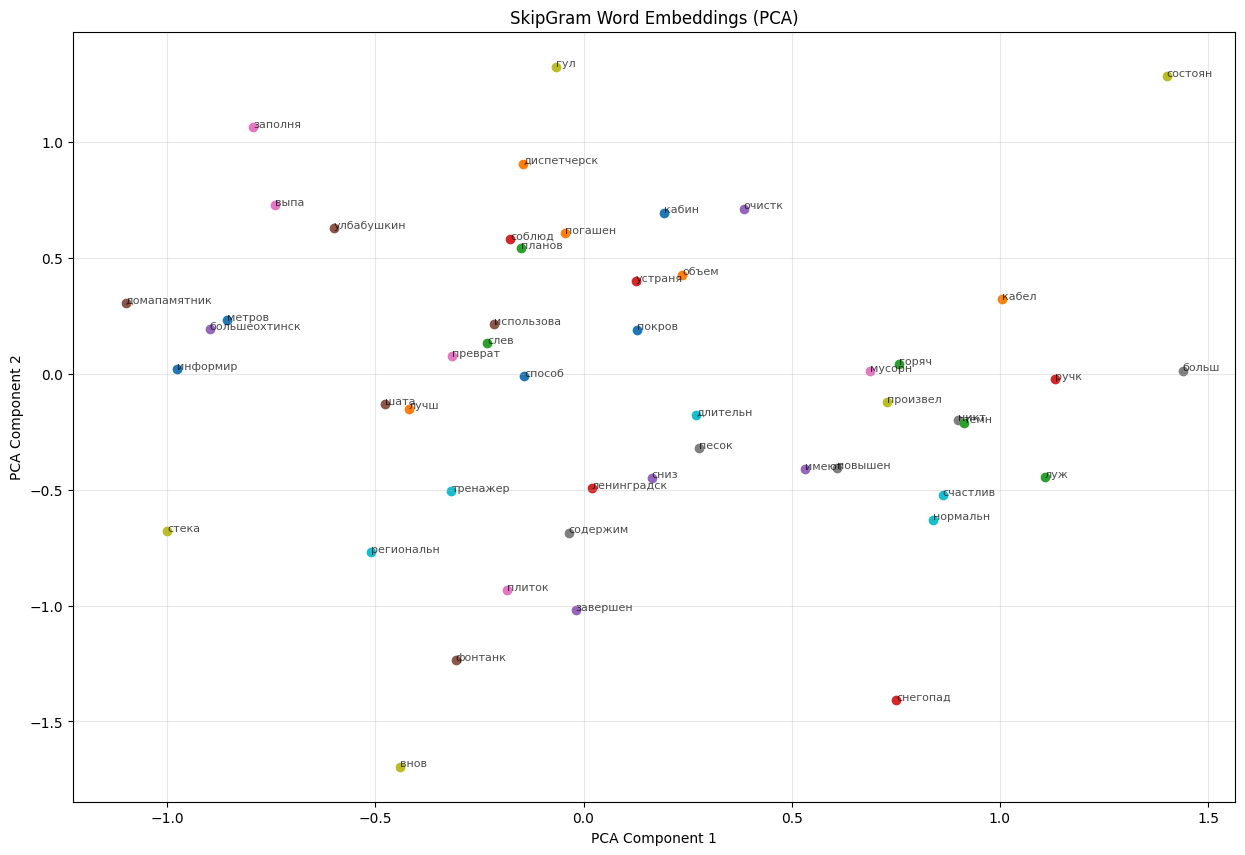

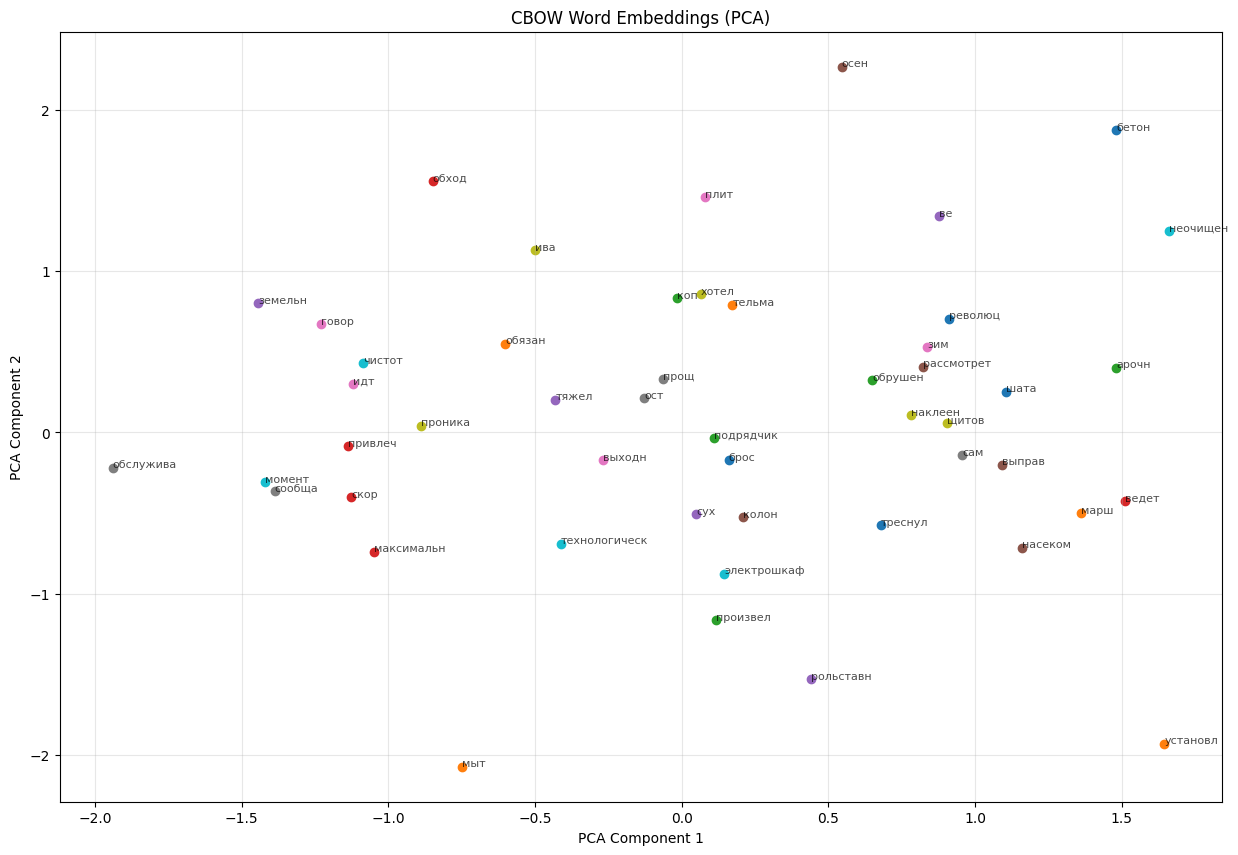

In [5]:
def get_embeddings(model, model_type='skipgram'):
    if model_type == 'skipgram':
        embeddings = model.input_embedding.weight.data.cpu().numpy()
    else:  # cbow
        embeddings = model.embeddings.weight.data.cpu().numpy()
    return embeddings

# Получение эмбеддингов
skipgram_embeddings = get_embeddings(skipgram_model, 'skipgram')
cbow_embeddings = get_embeddings(cbow_model, 'cbow')

print(f"Размерность SkipGram эмбеддингов: {skipgram_embeddings.shape}")
print(f"Размерность CBOW эмбеддингов: {cbow_embeddings.shape}")

# Уменьшение размерности с помощью PCA
def reduce_dimensionality(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Уменьшение размерности для визуализации
skipgram_2d = reduce_dimensionality(skipgram_embeddings, 2)
cbow_2d = reduce_dimensionality(cbow_embeddings, 2)

# Визуализация
def plot_embeddings(embeddings_2d, words, title, n_words=50):
    plt.figure(figsize=(15, 10))
    
    # Выбираем случайные слова для визуализации
    indices = np.random.choice(len(words), min(n_words, len(words)), replace=False)
    
    for i in indices:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
        plt.annotate(words[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    alpha=0.7, fontsize=8)
    
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Получение слов для визуализации
words = [preprocessor.reverse_vocab.get(i, '<UNK>') for i in range(len(preprocessor.reverse_vocab))]

# Визуализация SkipGram эмбеддингов
plot_embeddings(skipgram_2d, words, 'SkipGram Word Embeddings (PCA)')

# Визуализация CBOW эмбеддингов
plot_embeddings(cbow_2d, words, 'CBOW Word Embeddings (PCA)')

In [10]:
def save_embeddings_tsv(embeddings, words, filename):
    # Сохранение векторов
    with open(f'{filename}_vectors.tsv', 'w', encoding='utf-8') as f:
        for i in range(len(embeddings)):
            vector_str = '\t'.join(str(x) for x in embeddings[i])
            f.write(vector_str + '\n')
    
    # Сохранение меток
    with open(f'{filename}_metadata.tsv', 'w', encoding='utf-8') as f:
        for word in words:
            f.write(word + '\n')

# Сохранение SkipGram эмбеддингов
save_embeddings_tsv(skipgram_embeddings, words, 'skipgram_embeddings')

# Сохранение CBOW эмбеддингов  
save_embeddings_tsv(cbow_embeddings, words, 'cbow_embeddings')

print("Эмбеддинги сохранены в файлы:")
print("- skipgram_embeddings_vectors.tsv")
print("- skipgram_embeddings_metadata.tsv") 
print("- cbow_embeddings_vectors.tsv")
print("- cbow_embeddings_metadata.tsv")

Эмбеддинги сохранены в файлы:
- skipgram_embeddings_vectors.tsv
- skipgram_embeddings_metadata.tsv
- cbow_embeddings_vectors.tsv
- cbow_embeddings_metadata.tsv


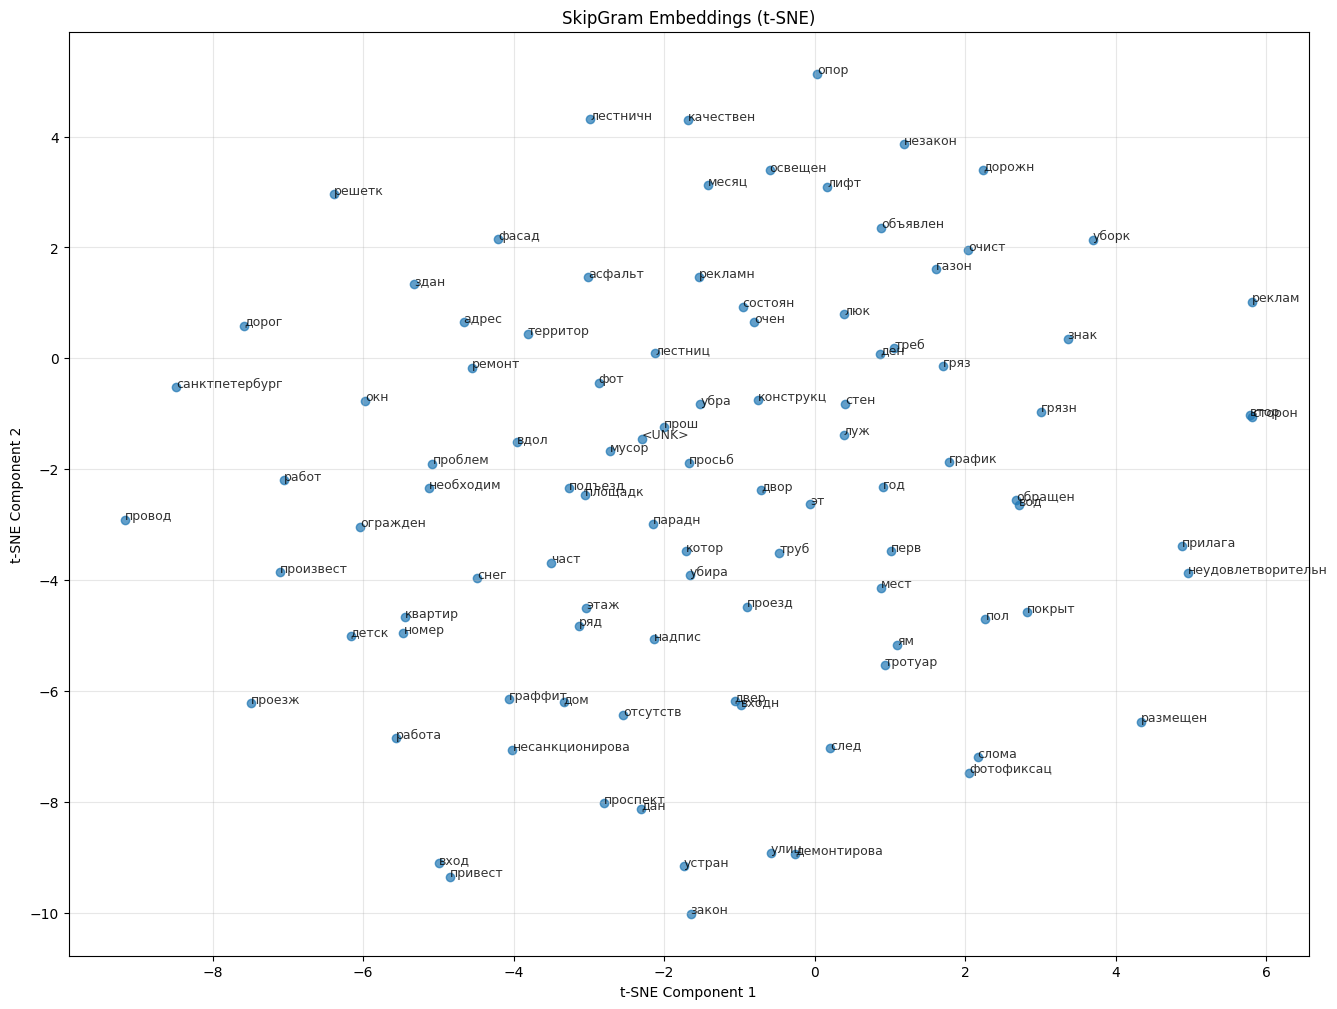

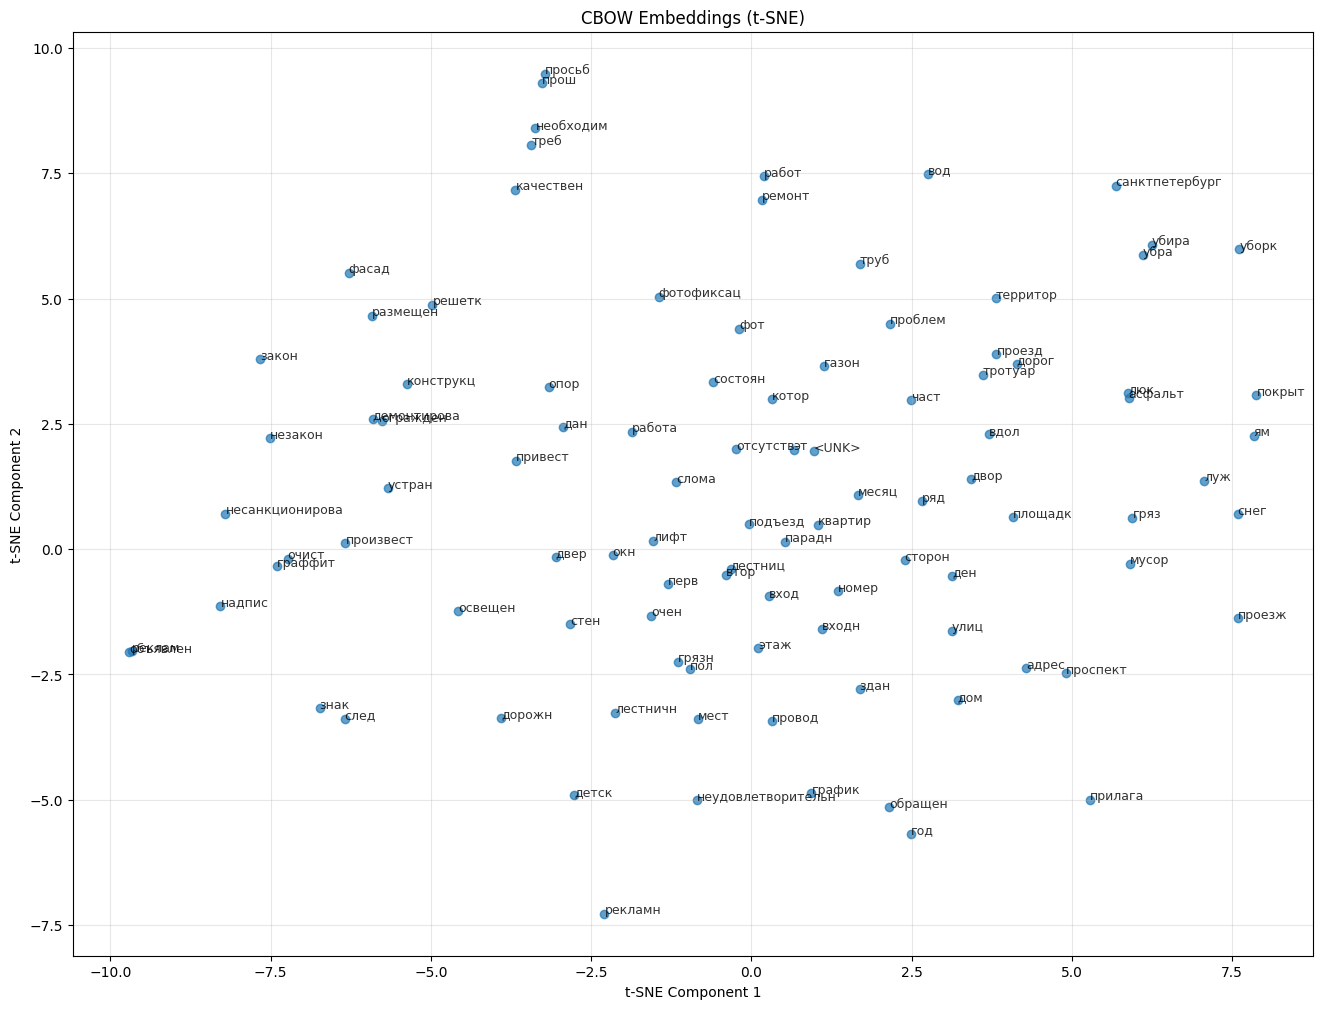

In [7]:
# Более качественная визуализация с t-SNE
def visualize_with_tsne(embeddings, words, title, n_words=100):
    # Выбираем наиболее частые слова
    word_freq = Counter()
    for sequence in sequences:
        word_freq.update(sequence)
    
    # Берем топ-N самых частых слов
    common_words_idx = [idx for idx, _ in word_freq.most_common(n_words)]
    common_words = [preprocessor.reverse_vocab.get(idx, '<UNK>') for idx in common_words_idx]
    
    # t-SNE уменьшение размерности
    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    embeddings_2d = tsne.fit_transform(embeddings[common_words_idx])
    
    # Визуализация
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    
    for i, word in enumerate(common_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    fontsize=9, alpha=0.8)
    
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Визуализация с t-SNE
visualize_with_tsne(skipgram_embeddings, words, 'SkipGram Embeddings (t-SNE)')
visualize_with_tsne(cbow_embeddings, words, 'CBOW Embeddings (t-SNE)')

In [11]:
from torch.utils.tensorboard import SummaryWriter

# Создание writer для TensorBoard
writer = SummaryWriter('runs/word2vec_experiment')

# Добавление эмбеддингов в TensorBoard
writer.add_embedding(skipgram_embeddings, metadata=words, tag='SkipGram_Embeddings')
writer.add_embedding(cbow_embeddings, metadata=words, tag='CBOW_Embeddings')

writer.close()

In [9]:
# Анализ качества эмбеддингов
def find_similar_words(word, embeddings, top_n=5):
    if word not in preprocessor.vocab:
        print(f"Слово '{word}' не найдено в словаре")
        return
    
    word_idx = preprocessor.vocab[word]
    word_vector = embeddings[word_idx]
    
    # Вычисление косинусного сходства
    similarities = {}
    for idx, vector in enumerate(embeddings):
        if idx != word_idx and idx != 0 and idx != 1:  # Исключаем PAD и UNK
            cos_sim = np.dot(word_vector, vector) / (np.linalg.norm(word_vector) * np.linalg.norm(vector))
            word_text = preprocessor.reverse_vocab.get(idx, '<UNK>')
            similarities[word_text] = cos_sim
    
    # Топ-N наиболее похожих слов
    similar_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    print(f"Слова, похожие на '{word}':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.4f}")

# Тестирование на примерах
test_words = ['дом', 'управ', 'ремонт', 'вода', 'отоплен']  # Примеры слов

print("SkipGram похожие слова:")
for word in test_words:
    find_similar_words(word, skipgram_embeddings)

print("\nCBOW похожие слова:")
for word in test_words:
    find_similar_words(word, cbow_embeddings)

SkipGram похожие слова:
Слова, похожие на 'дом':
  отсутств: 0.5646
  улиц: 0.5308
  парадн: 0.5284
  квартир: 0.5225
  мусор: 0.5218
Слово 'управ' не найдено в словаре
Слова, похожие на 'ремонт':
  оста: 0.4686
  дом: 0.4625
  очистк: 0.4521
  адрес: 0.4423
  сам: 0.4423
Слово 'вода' не найдено в словаре
Слова, похожие на 'отоплен':
  магазин: 0.4966
  действительн: 0.3827
  вод: 0.3779
  решен: 0.3731
  доступ: 0.3721

CBOW похожие слова:
Слова, похожие на 'дом':
  суздальск: 0.4513
  королев: 0.4497
  оптик: 0.3858
  непокорен: 0.3649
  ближ: 0.3562
Слово 'управ' не найдено в словаре
Слова, похожие на 'ремонт':
  вернут: 0.3820
  работ: 0.3705
  прочист: 0.3578
  сумм: 0.3500
  снача: 0.3474
Слово 'вода' не найдено в словаре
Слова, похожие на 'отоплен':
  оцен: 0.3968
  профилактик: 0.3765
  засыпа: 0.3728
  осуществля: 0.3719
  александр: 0.3698
